In [112]:
from dataclasses import dataclass, field
from typing import Optional
import sys
sys.path.append('/scratch/2023-fall-sp-le/langseg')

import torch
from torch import nn
from torch.nn import functional as F
torch.backends.cuda.matmul.allow_tf32 = True
from transformers import CLIPProcessor, CLIPModel
from diffusers import StableDiffusionPipeline
from tqdm import tqdm

import cv2
import numpy as np
from PIL import Image
from  matplotlib import pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
from methods.prompt_engineering import extract_class_embeddings, extract_clip_text_embeddings
BICUBIC = InterpolationMode.BICUBIC

from datasets.coco_stuff import coco_stuff_categories, coco_stuff_171_to_27
from datasets.cityscapes import cat_to_label_id as cityscapes_cats
from datasets.utils import get_dataset
from utils.metrics import RunningScore
from utils.plotting import *

from methods.diffusion_patch import *
from methods.diffusion import *
from methods.diffusion_seg import *
from methods.diffusion_utils import *
from methods.text_embeddings import *
from methods.diffseg import *
from methods.prompt_engineering import *

# pip install --upgrade diffusers transformers nltk accelerate torch_kmeans igraph peft compel torchvision ftfy open_clip_torch einops
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
@dataclass
class SegmentationConfig:
    dir_dataset: str = field(
        default="/sinergia/ozaydin/segment/STEGO-master/data/cocostuff", metadata={"help": "dir dataset"}
    )
    dataset_name: str = field(
        default="voc2012", metadata={"help": "for get_dataset"}
    )
    split: str = field(
        default="train", metadata={"help": "which split to use"}
    )
    resolution: int = field(
        default=512, metadata={"help": "resolution of the images, e.g, 512, 768, 1024"}
    )
    mask_res: int = field(
        default=320, metadata={"help": "resolution of the masks, e.g, 64, 320, 512"}
    )
    dense_clip_arch: str = field(
        default="RN50x16", metadata={"help": "not used in cocostuff"}
    )

args = SegmentationConfig()

# @dataclass
# class SegmentationConfig:
#     dir_dataset: str = field(
#         default="/scratch/2023-fall-sp-le/data/VOCdevkit/VOC2010", metadata={"help": "dir dataset"}
#     )
#     dataset_name: str = field(
#         default="pascal_context", metadata={"help": "for get_dataset"}
#     )
#     split: str = field(
#         default="train", metadata={"help": "which split to use"}
#     )
#     resolution: int = field(
#         default=512, metadata={"help": "resolution of the images, e.g, 512, 768, 1024"}
#     )
#     mask_res: int = field(
#         default=320, metadata={"help": "resolution of the masks, e.g, 64, 320, 512"}
#     )
#     dense_clip_arch: str = field(
#         default="RN50x16", metadata={"help": "not used in cocostuff"}
#     )

# args = SegmentationConfig()

# @dataclass
# class SegmentationConfig:
#     dir_dataset: str = field(
#         default="/sinergia/ozaydin/segment/STEGO-master/data/cocostuff", metadata={"help": "dir dataset"}
#     )
#     dataset_name: str = field(
#         default="coco_stuff", metadata={"help": "for get_dataset"}
#     )
#     split: str = field(
#         default="val", metadata={"help": "which split to use"}
#     )
#     resolution: int = field(
#         default=512, metadata={"help": "resolution of the images, e.g, 512, 768, 1024"}
#     )
#     mask_res: int = field(
#         default=320, metadata={"help": "resolution of the masks, e.g, 64, 320, 512"}
#     )
#     dense_clip_arch: str = field(
#         default="RN50x16", metadata={"help": "not used in cocostuff"}
#     )

# args = SegmentationConfig()

In [3]:
dataset, categories, palette = get_dataset(
    dir_dataset=args.dir_dataset,
    dataset_name=args.dataset_name,
    split=args.split,
    resolution=args.resolution,
    mask_res=args.mask_res,
    dense_clip_arch=args.dense_clip_arch
)

if args.dataset_name == "coco_stuff":
    label_id_to_cat = categories if not dataset.use_27 else coco_stuff_categories
    cat_to_label_id = {v: i for i, v in enumerate(label_id_to_cat)}
elif args.dataset_name == "cityscapes":
    cat_to_label_id = cityscapes_cats
    label_id_to_cat = {i: c for c, i in cat_to_label_id.items()}
elif args.dataset_name == "voc2012" or args.dataset_name == "pascal_context":
    label_id_to_cat = categories
    cat_to_label_id = {v: i for i, v in enumerate(label_id_to_cat)}

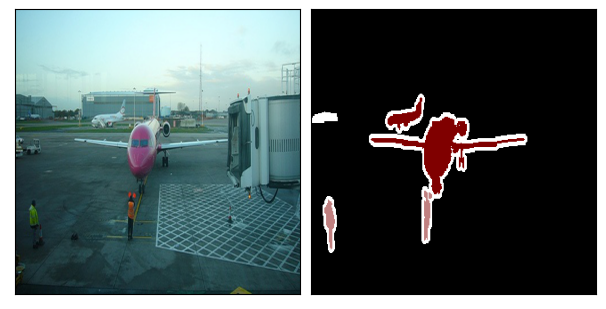

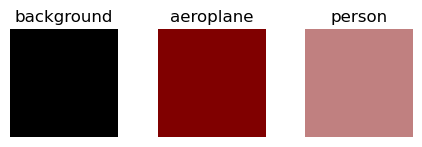

In [107]:
idxx = 0#69
val_img = dataset[idxx]["img"].cpu().numpy()
val_gt = dataset[idxx]["gt"].cpu().numpy()

# label_27 = np.zeros_like(val_gt)
# for fine, coarse in coco_stuff_171_to_27.items():
#     label_27[val_gt == fine] = coarse

# val_gt = label_27

lab_ids = sorted(list(np.unique(val_gt)))
lab_ids = np.array(lab_ids[1:])
val_pil_img = render_results(val_img, val_gt, palette)
_ = get_legends(lab_ids, palette, label_id_to_cat, is_voc2012 = args.dataset_name == "voc2012")

val_gt = dataset[idxx]["gt"].unsqueeze(0)
val_labels = sorted(np.unique(val_gt))
val_labels = [l for l in val_labels if l != -1] # don't process label -1 (ignored unlabelled pixels)
val_labels = [label_id_to_cat[c] for c in val_labels]
val_labels = [l for l in val_labels if l != "background"] # don't feed "background" as text input

## Diffusion

In [ ]:
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16,
    use_safetensors=True, variant="fp16",
    # device_map="auto"
)
pipe = pipe.to("cuda")
configure_ldm(pipe)

In [ ]:
orig_unet_methods, _ = extract_original_attn_methods(pipe.unet)

In [ ]:
handles = {}
attention_layers_to_use = ATTENTION_LAYERS
attention_store = AttentionStore(low_resource=False, no_uncond=True, layer_keys=attention_layers_to_use)
attention_store.num_att_layers = len(attention_layers_to_use)
handles = register_attention_hooks(pipe.unet, attention_store, attention_layers_to_use, handles)

In [ ]:
restore_original_attn_methods(pipe.unet, orig_unet_methods)
attention_store.layer_keys = ATTENTION_LAYERS
attention_store.num_att_layers = len(attention_store.layer_keys)
attention_store.no_uncond = False
handles = register_attention_hooks(pipe.unet, attention_store, attention_store.layer_keys, handles)

### Method 1

In [ ]:
# uncond pass for self attn
val_img = dataset[idxx]["img"].permute(1,2,0)[None,...].numpy()
text_embeds, concept_ind, concept_indices, _ = get_label_embeddings(
    pipe.tokenizer, pipe.text_encoder, ["aeroplane"], label_id_to_cat, cat_to_label_id,
    use_compel=False
)
val_img = val_img.repeat(len(text_embeds), axis=0)
attention_store.reset()
training_step(pipe, text_embeds, val_img, attention_store, no_uncond=False, normalize=False, low_resource=False)
selfattn_maps = {k: v for k, v in attention_store.attention_store.items() if "attn1" in k}

In [ ]:
restore_original_attn_methods(pipe.unet, orig_unet_methods)
attention_store.layer_keys = [a for a in ATTENTION_LAYERS if "attn2" in a]
attention_store.num_att_layers = len(attention_store.layer_keys)
attention_store.no_uncond = True
handles = register_attention_hooks(pipe.unet, attention_store, attention_store.layer_keys, handles)

In [ ]:
# cond pass for cross attn
val_img = dataset[idxx]["img"].permute(1,2,0)[None,...].numpy()
text_embeds, concept_ind, concept_indices, _ = get_label_embeddings(
    pipe.tokenizer, pipe.text_encoder, val_labels, label_id_to_cat, cat_to_label_id,
    use_compel=False
)
val_img = val_img.repeat(len(text_embeds), axis=0)
attention_store.reset()
training_step(pipe, text_embeds, val_img, attention_store, no_uncond=True, normalize=False, low_resource=False)
crossattn_maps = {k: v for k, v in attention_store.attention_store.items() if "attn2" in k}

In [ ]:
crossattn_maps.update(selfattn_maps)

In [ ]:
ca, sa = get_attention_maps(
    crossattn_maps,
    label_indices=concept_indices,
    output_size=64,
    average_layers=True,
    apply_softmax=True,
    softmax_dim=-1,
    simple_average=False
)
ca_bg = ca[..., 0].mean(dim=0).unsqueeze(-1)
ca = torch.cat([ca_bg, ca[..., 5].t()], dim=-1).unsqueeze(0)
agg_map = get_agg_map(ca, sa, walk_len=1, beta=1)

In [ ]:
pred_mask_0 = get_random_walk_mask(
    agg_map, cat_to_label_id,
    list(range(len(val_labels)+1)), ["background"]+val_labels, args.mask_res
)
pred_mask_0 = pred_mask_0.long().cpu().numpy()

In [ ]:
plt.imshow(pred_mask_0[0])

In [ ]:
running_score_0 = RunningScore(len(label_id_to_cat))

pbar = tqdm(range(len(dataset)))
for idx in pbar:
    val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
    val_gt = dataset[idx]["gt"].unsqueeze(0)
    val_labels = sorted(np.unique(val_gt))
    val_labels = [l for l in val_labels if l != -1] # don't process label -1 (ignored unlabelled pixels)
    val_labels = [label_id_to_cat[c] for c in val_labels]
    val_labels = [l for l in val_labels if l != "background"] # don't feed "background" as text input) != 1: continue

    restore_original_attn_methods(pipe.unet, orig_unet_methods)
    attention_store.layer_keys = ATTENTION_LAYERS
    attention_store.num_att_layers = len(attention_store.layer_keys)
    attention_store.no_uncond = False
    handles = register_attention_hooks(pipe.unet, attention_store, attention_store.layer_keys, handles)

    # uncond pass for self attn
    val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
    text_embeds, concept_ind, concept_indices, _ = get_label_embeddings(
        pipe.tokenizer, pipe.text_encoder, ["aeroplane"], label_id_to_cat, cat_to_label_id,
        use_compel=False
    )
    val_img = val_img.repeat(len(text_embeds), axis=0)
    attention_store.reset()
    training_step(pipe, text_embeds, val_img, attention_store, no_uncond=False, normalize=False, low_resource=False)
    selfattn_maps = {k: v for k, v in attention_store.attention_store.items() if "attn1" in k}

    restore_original_attn_methods(pipe.unet, orig_unet_methods)
    attention_store.layer_keys = [a for a in ATTENTION_LAYERS if "attn2" in a]
    attention_store.num_att_layers = len(attention_store.layer_keys)
    attention_store.no_uncond = True
    handles = register_attention_hooks(pipe.unet, attention_store, attention_store.layer_keys, handles)

    # cond pass for cross attn
    val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
    text_embeds, concept_ind, concept_indices, _ = get_label_embeddings(
        pipe.tokenizer, pipe.text_encoder, val_labels, label_id_to_cat, cat_to_label_id,
        use_compel=False
    )
    val_img = val_img.repeat(len(text_embeds), axis=0)
    attention_store.reset()
    training_step(pipe, text_embeds, val_img, attention_store, no_uncond=True, normalize=False, low_resource=False)
    crossattn_maps = {k: v for k, v in attention_store.attention_store.items() if "attn2" in k}
    crossattn_maps.update(selfattn_maps)
    
    ca, sa = get_attention_maps(
        crossattn_maps,
        label_indices=concept_indices,
        output_size=64,
        average_layers=True,
        apply_softmax=True,
        softmax_dim=-1,
        simple_average=False
    )
    ca_bg = ca[..., 0].mean(dim=0).unsqueeze(-1)
    ca = torch.cat([ca_bg, ca[..., 5].t()], dim=-1).unsqueeze(0)
    agg_map = get_agg_map(ca, sa, walk_len=1, beta=1, minmax_norm=True)
    pred_mask_0 = get_random_walk_mask(
        agg_map, cat_to_label_id,
        list(range(len(val_labels)+1)), ["background"]+val_labels, args.mask_res
    )
    pred_mask_0 = pred_mask_0.long().cpu().numpy()

    running_score_0.update(val_gt.cpu().numpy(), pred_mask_0)
    metrics_0, cls_iou_0 = running_score_0.get_scores()
    miou_0 = metrics_0["Mean IoU"]

    pbar.set_description(
        f"mIoU_0 {miou_0:.3f} | "
    )

In [ ]:
print({k: f"{v*100:.1f}" for k, v in metrics_0.items()})
print({label_id_to_cat[i]: f"{v*100:.1f}" for i, v in cls_iou_0.items()})

### Method 2

In [ ]:
from compel import Compel

compel_proc = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder, device=pipe.text_encoder.device)
prompt = '["a photo of", chair", "dog"].and()'
text_embeds = compel_proc(prompt)

In [ ]:
val_img = dataset[idxx]["img"].permute(1,2,0)[None,...].numpy()
val_img = val_img.repeat(len(text_embeds), axis=0)
attention_store.reset()
training_step(pipe, text_embeds, val_img, attention_store, no_uncond=True, normalize=False, low_resource=False)

In [ ]:
show_cross_attention(attention_store, 8, ["a photo of chair, dog, a, b, c, d"], pipe.tokenizer, select=0)

## GEM

In [5]:
import torch
from methods import gem
import requests
from PIL import Image

# model_name = 'ViT-B/16'  # 'ViT-B-16-quickgelu'
# pretrained = 'openai'  # 'metaclip_400m'
model_name = 'ViT-B/16-quickgelu'
# model_name = 'ViT-L/14-quickgelu'
pretrained = 'metaclip_400m'
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# init model and image transform
gem_model = gem.create_gem_model(model_name=model_name,
                                 pretrained=pretrained, 
                                 device=device)

In [6]:
# load image and text
preprocess = gem.get_gem_img_transform(img_size=(448, 448))
image = preprocess(Image.open(dataset[idxx]["p_img"])).unsqueeze(0).to(device)
class_names = label_id_to_cat[1:]
with torch.no_grad():
    logits = gem_model(image, class_names, normalize=False, return_ori=False)  # [1, num_class, W, H]

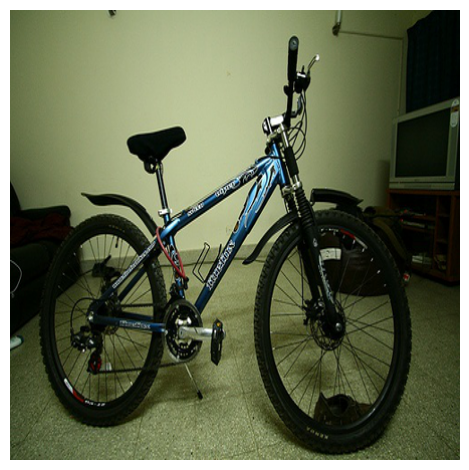

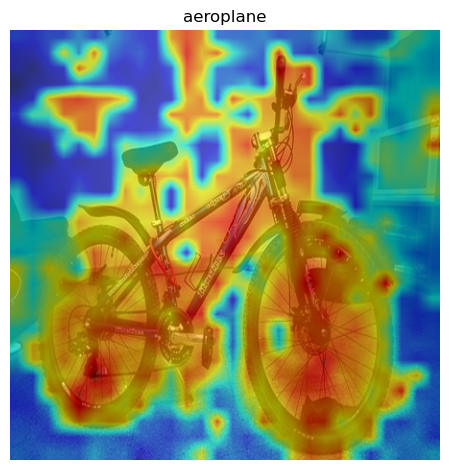

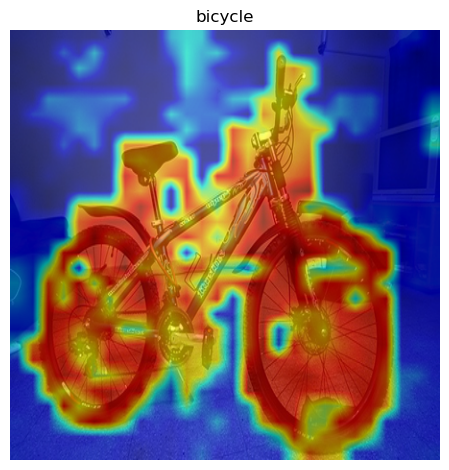

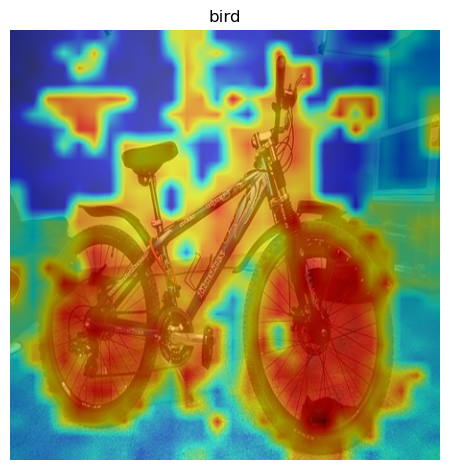

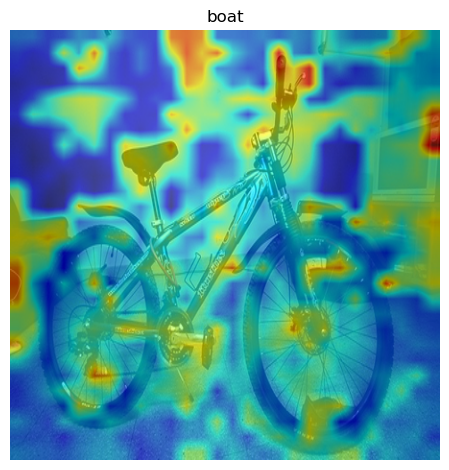

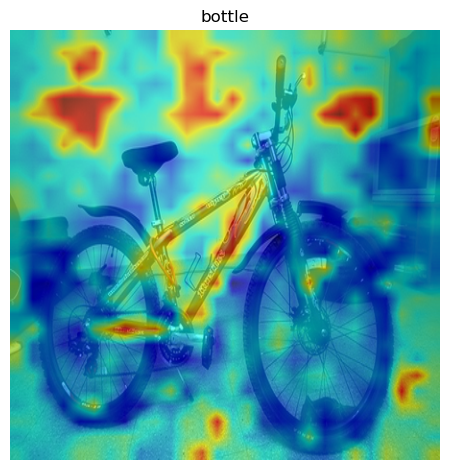

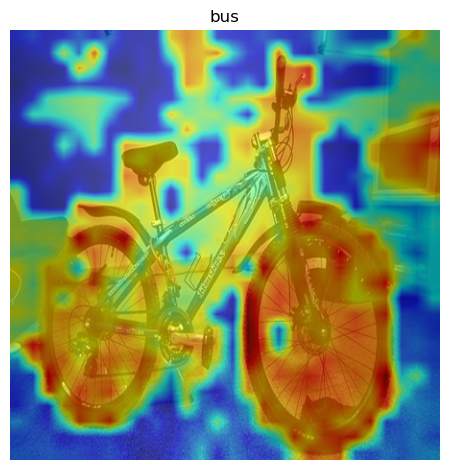

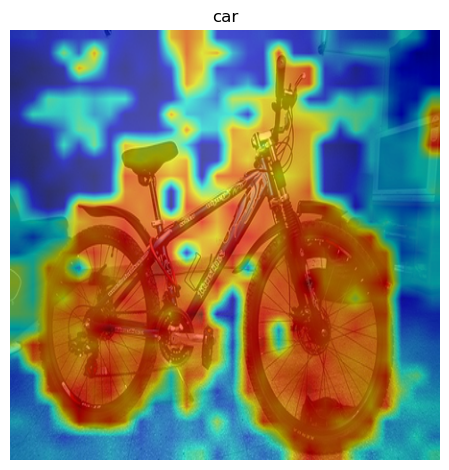

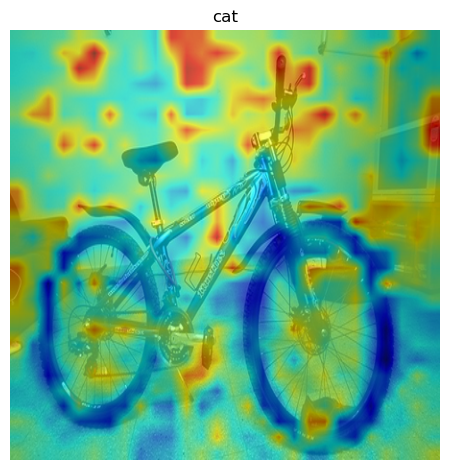

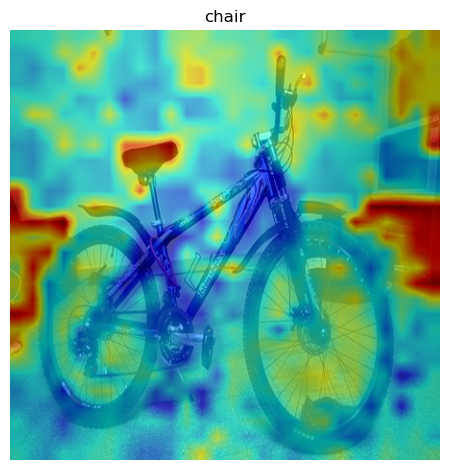

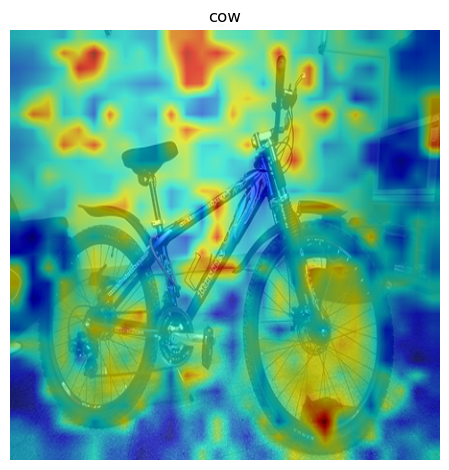

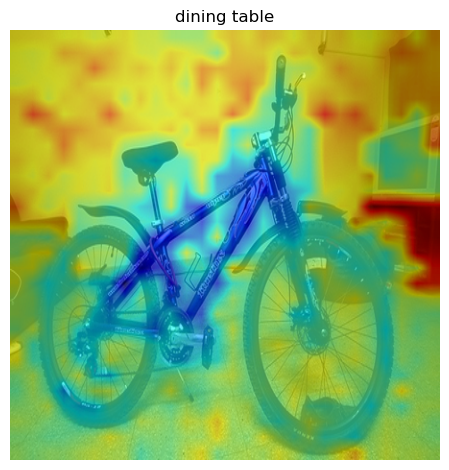

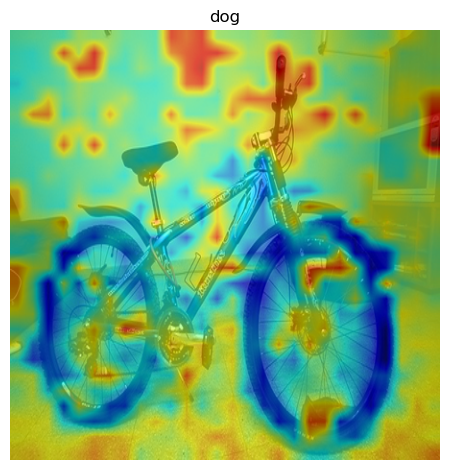

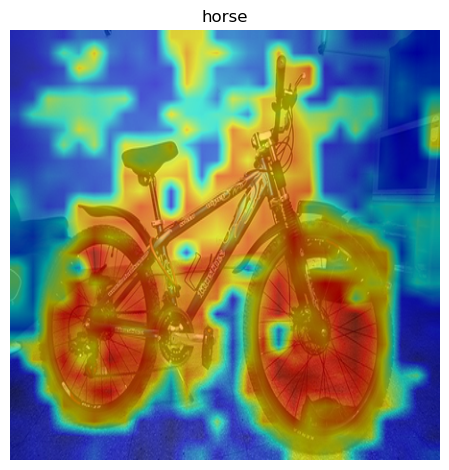

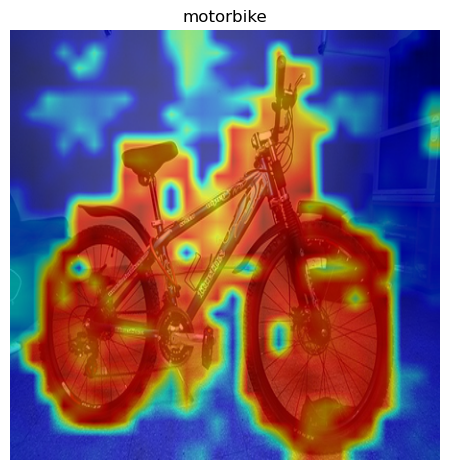

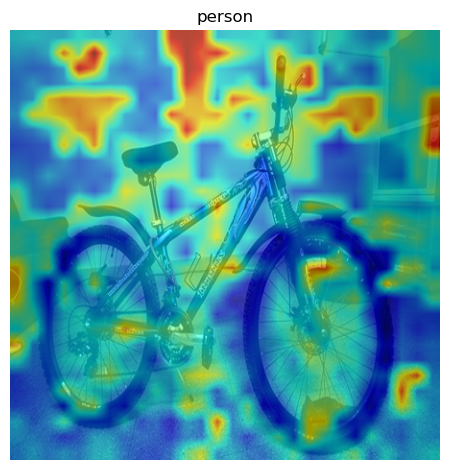

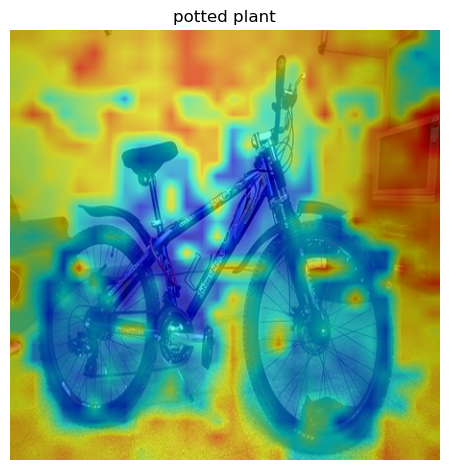

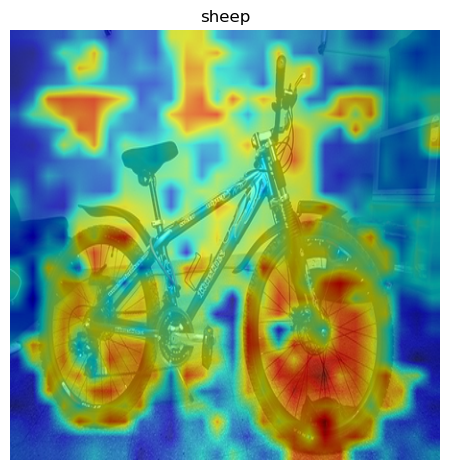

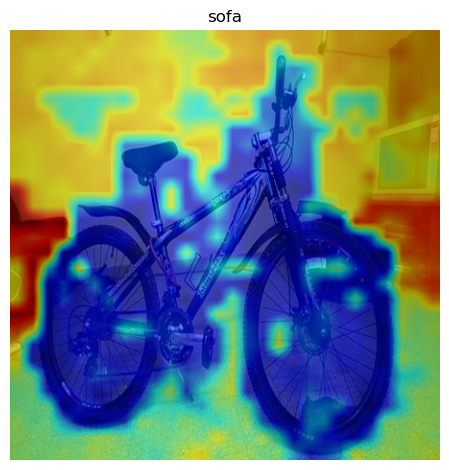

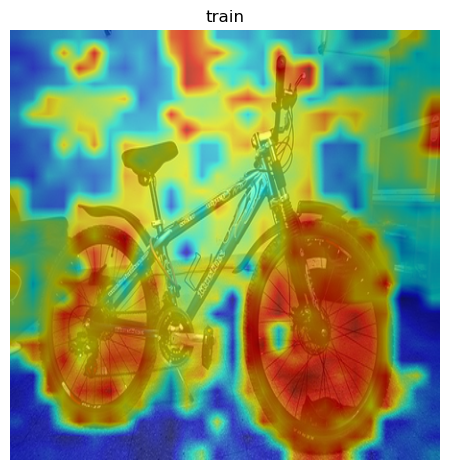

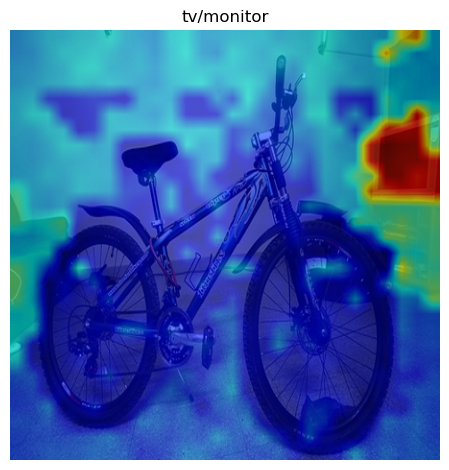

In [7]:
normed_logits = gem_model.min_max(logits)
gem.visualize(image, class_names, normed_logits)  # (optional visualization)

In [7]:
# def normalize_ca(ca, lab_ids=None):
#     # ca: (b, h, w, k) or (b, hw, k)
#     # normalize over hw
#     input_ndim = ca.ndim
#     bsz = ca.shape[0]
#     if lab_ids is None:
#         lab_ids = torch.arange(ca.shape[-1])
#     ca = ca[..., lab_ids]
#     if input_ndim == 4:
#         ca = ca.view(bsz, -1, len(lab_ids))
#     # min-max normalize spatially
#     min_val = ca.min(dim=1, keepdim=True).values
#     max_val = ca.max(dim=1, keepdim=True).values
#     ca = (ca - torch.abs(min_val)) / (max_val - min_val + 1e-10)
#     if input_ndim == 4:
#         res = int(ca.shape[1]**0.5)
#         ca = ca.view(bsz, res, res, -1)
#     return ca


# def get_agg_map(ca, sa, concept_ind=None, beta=1, walk_len=1, minmax_norm=True):
#     # this is the random walk algorithm
#     # ca: (bsz, hw, k)
#     # sa: (bsz, hw, hw)
#     assert ca.ndim == 3
#     assert sa.ndim == 3
#     # ca: probability vector, ca[i,k] = prob random walk at pixel i for each class k
#     # ca = normalize_ca(ca)
#     # ca = ca / (ca.sum(dim=-2, keepdim=True)+1e-10)
#     # ca = ca.softmax(dim=-2)
#     sa = sa.permute(0, 2, 1) # (bsz, (h,w), hw)
#     sa = torch.pow(sa, beta)
#     sa = sa / sa.sum(dim=-1, keepdim=True) # sa = transition matrix (row sum = 1)
#     sa = torch.linalg.matrix_power(sa, walk_len)
#     agg_map = torch.bmm(sa, ca) # (bsz, hw, k)
#     if minmax_norm:
#         agg_map = normalize_ca(agg_map)
#     return agg_map

In [7]:
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16,
    use_safetensors=True, variant="fp16",
    # device_map="auto"
)
pipe = pipe.to("cuda")
configure_ldm(pipe)

handles = {}
attention_layers_to_use = ATTENTION_LAYERS
attention_store = AttentionStore(low_resource=False, no_uncond=True, layer_keys=attention_layers_to_use)
attention_store.num_att_layers = len(attention_layers_to_use)
handles = register_attention_hooks(pipe.unet, attention_store, attention_layers_to_use, handles)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [8]:
def prompt_denoising(logits):
    pd_thresh = 0.5
    logits = logits.clone()
    N, C, H, W = logits.shape
    _output = F.softmax(logits*100, dim=1)
    max_cls_conf = _output.view(N, C, -1).max(dim=-1)[0]
    selected_cls = (max_cls_conf < pd_thresh)[:, :, None, None].expand(N, C, H, W)
    logits[selected_cls] = -100
    return logits

def filter_prompt(logits, val_labels, cat_to_label_id):
    # logits (N, C, H, W)
    concept_ind = []
    for c, v in cat_to_label_id.items():
        concept_ind.append(c not in val_labels)
    concept_ind = torch.tensor([concept_ind]).to(logits.device)
    logits = logits.clone()
    logits[concept_ind] = -100
    return logits

In [113]:
# def run_specclust_torch(A, n_clusters=9, n_vecs=10, output_size=None, decomp="svd"):
#     assert A.ndim == 3
#     bsz, res = A.shape[0], int(A.shape[1]**0.5)
#     if decomp == "svd":
#         D1 = torch.diagflat(1/A.sum(dim=-1).sqrt()).unsqueeze(0)
#         D2 = torch.diagflat(1/A.sum(dim=-2).sqrt()).unsqueeze(0)
#         A = torch.bmm(D1, torch.bmm(A, D2))
#         u, s, vh = torch.linalg.svd(A, full_matrices=False)
#         u = torch.bmm(D1, u[..., :n_vecs]) # (bsz, hw, n_vecs) # u = torch.bmm(D2, vh[:, :n_vecs].permute(0, 2, 1))
#     elif decomp == "eig":
#         A = (A + A.permute(0,2,1))/2
#         D = torch.diagflat(A.sum(dim=-1)).unsqueeze(0) # row sums
#         eigvals, eigvecs = torch.lobpcg(A, B=D, k=n_vecs)
#         u = eigvecs
#     clusters = KMeans(init_method="k-means++", n_clusters=n_clusters, verbose=False)(u).labels
#     clusters = clusters.view(bsz, res, res)
#     if output_size is not None:
#         clusters = F.interpolate(clusters.unsqueeze(1).float(), size=output_size, mode='nearest').squeeze(1)
#     return clusters.long()


def assign_names_to_clusters(clusters, ca, concept_ind, concepts, output_size=None, voting="mean", bg_thresh=0.35):
    # ca: (b, hw, k)
    assert ca.ndim == 3
    bsz, res = ca.shape[0], int(ca.shape[1]**0.5)
    assert bsz == clusters.shape[0]
    if output_size is not None:
        nca = upscale_attn(ca, output_size, is_cross=True)
        res = output_size
    else:
        nca = ca
    # nca = normalize_ca(nca)
    # nca[..., concept_ind] = normalize_ca(nca, concept_ind)
    cluster_names = {}
    for c in clusters.unique().tolist():
        if c == -1: continue
        if voting == "majority":
            logits = nca[(clusters == c).view(bsz,-1)].to("cpu", torch.float).numpy()
            index = logits.argmax(axis=-1)
            category = nouns[int(np.median(index))]
        else:
            scores = nca[(clusters == c).view(bsz,-1)].mean(dim=0)
            scores = scores[..., concept_ind]
            category = concepts[torch.argmax(scores)] # if scores.max() > bg_thresh else "background"
        cluster_names[c] = category
    return cluster_names


def get_specclust_mask(
    ca, sa,
    cat_to_label_id: dict,
    concept_ind: list, concepts: list,
    output_size=None, bg_thresh=0.35,
    method="torch", decomp="svd",
    clusters=None
):
    clust_method = run_specclust_torch
    kwargs = {"decomp": decomp} if method == "torch" else {}
    if clusters is None:
        clusters = clust_method(sa, n_clusters=21, n_vecs=20, output_size=output_size, **kwargs)
    cluster_names = assign_names_to_clusters(clusters, ca, concept_ind, concepts, output_size=output_size, bg_thresh=bg_thresh)
    # print(cluster_names)
    pred_mask = torch.zeros_like(clusters)
    for k in cluster_names.keys(): # cluster_id -> cluster_name (label name) -> label_id
        pred_mask[clusters == k] = cat_to_label_id[cluster_names[k]]
    return pred_mask

In [114]:
nouns = label_id_to_cat
concept_ind = [cat_to_label_id[c] for c in nouns]
ca = probs
ca = ca.view(*ca.shape[:2], -1).permute(0, 2, 1)
pred_mask = get_specclust_mask(
    ca, sa, cat_to_label_id,
    concept_ind, nouns,
    output_size=args.mask_res#, clusters=val_gt.cuda()
)

In [216]:
print({cat_to_label_id[c]: c for c in val_labels})

{25: 'floor', 36: 'person', 52: 'tree', 55: 'wall'}


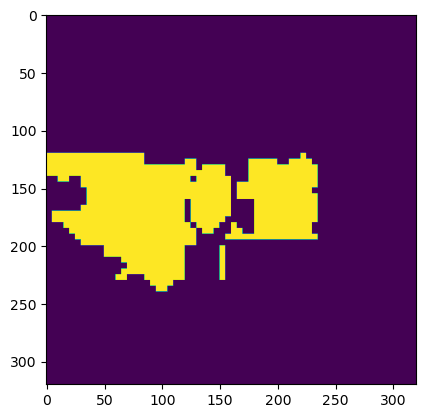

In [115]:
plt.imshow(pred_mask[0].cpu())

In [ ]:
grid = generate_sampling_grid(16, res=64) # 32
grid = torch.from_numpy(grid).to(device)
kl_threshold = [0.75]*3 # 0.8
weights = sa.reshape(64, 64, 64, 64)
pred = generate_masks(weights, kl_threshold, grid, out_res=320, refine=True)[None]

remap = {}
for c in pred.unique().tolist():
    region = (pred == c).flatten()
    region_repr = logits[:, region].mean(dim=1, keepdim=True)
    pred_cls = region_repr.argmax(dim=-1).squeeze().item()
    remap[c] = pred_cls
remap = (torch.tensor(list(remap.keys())), torch.tensor(list(remap.values())))
pred = remap_values(remap, pred)

plt.imshow(pred[0].cpu())
print({i: label_id_to_cat[i] for i in pred[0].unique().tolist()})

In [74]:
pred_mask.unique().tolist()

[0, 25, 36, 52, 55]

In [75]:
print({i: label_id_to_cat[i] for i in pred_mask.unique().tolist()})

{0: 'aeroplane', 25: 'floor', 36: 'person', 52: 'tree', 55: 'wall'}


In [37]:
# gem_model.text_embeddings = extract_clip_text_embeddings(gem_model.model, gem_model.tokenizer, label_id_to_cat[1:]).unsqueeze(0)

In [108]:
image = preprocess(Image.open(dataset[idxx]["p_img"])).unsqueeze(0).to(device)
with torch.no_grad():
    logits = gem_model(image, class_names, output_size=64, normalize=False)

# logits = prompt_denoising(logits)
# logits = filter_prompt(logits, val_labels, cat_to_label_id)
# probs = (logits * 100).softmax(dim=1)
# bg_probs = 1 - probs.max(dim=1)[0]
# probs = torch.cat([bg_probs[None], probs], dim=1)

probs = gem_model.min_max(probs)
probs = (logits * 10).softmax(dim=1) # without softmax -> person class VERY bad
max_probs = probs.max(dim=1)[0]
bg_probs = 1 - max_probs - 0.8
# bg_probs = torch.where(bg_probs > 0, bg_probs, 0)
# bg_probs = probs.max() - probs.max(dim=1)[0]
probs = torch.cat([bg_probs[None], probs], dim=1)

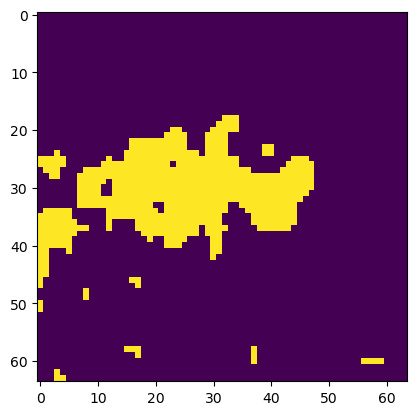

In [92]:
plt.imshow(probs.argmax(dim=1)[0].cpu())

In [93]:
pred = probs.argmax(dim=1)
print({i: label_id_to_cat[i] for i in pred.unique().tolist()})

{0: 'background', 1: 'aeroplane'}


In [94]:
# uncond pass for self attn
val_img = dataset[idxx]["img"].permute(1,2,0)[None,...].numpy()
attention_store.reset()
text_embeds = get_text_embeddings_simple(pipe.tokenizer, pipe.text_encoder, "")
val_img = val_img.repeat(len(text_embeds), axis=0)
training_step(pipe, text_embeds, val_img, attention_store, no_uncond=True, normalize=False, low_resource=False)
ca, sa = get_attention_maps(
    attention_store.get_average_attention(),
    batch_size=len(text_embeds),
    label_indices=None,
    output_size=64,
    average_layers=True,
    apply_softmax=True,
    softmax_dim=-1,
    simple_average=False
)

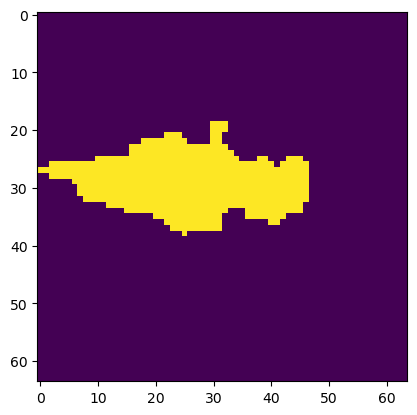

In [95]:
# bg_scores = 1 - probs.max(dim=1).values
# ca = torch.cat([bg_scores[None], probs], dim=1)
ca = probs
ca = ca.view(*ca.shape[:2], -1).permute(0, 2, 1)
agg_map = get_agg_map(ca, sa, walk_len=1, beta=1, minmax_norm=False, ca_norm=False)
# agg_map = agg_map / (agg_map.sum(dim=1, keepdim=True)+1e-10)
# agg_map = ca
# ppls = (-agg_map[...,1:] * agg_map[...,1:].log()).sum(dim=-1).exp()
pred = agg_map.argmax(dim=-1)
plt.imshow(pred.view(64,64).cpu())

In [96]:
print({i: label_id_to_cat[i] for i in pred.unique().tolist()})

{0: 'background', 1: 'aeroplane'}


In [137]:
print({label_id_to_cat[i]: (pred == i).sum().item() for i in pred.unique()})

{'bag': 10, 'building': 113, 'bus': 25, 'cabinet': 893, 'curtain': 1, 'door': 125, 'floor': 138, 'motorbike': 64, 'mouse': 14, 'person': 749, 'platform': 6, 'pottedplant': 10, 'rock': 54, 'sidewalk': 3, 'sign': 13, 'snow': 20, 'tree': 1818, 'truck': 1, 'tvmonitor': 1, 'water': 38}


In [119]:
def run_gem_diff_voc():
    from tqdm import tqdm
    preprocess = gem.get_gem_img_transform(img_size=(448, 448))
    running_score = RunningScore(len(label_id_to_cat))
    rs = RunningScore(len(label_id_to_cat))
    pbar = tqdm(range(len(dataset)))
    # qs = []
    for idx in pbar:
        val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
        val_gt = dataset[idx]["gt"].unsqueeze(0)
        val_labels = sorted(np.unique(val_gt))
        val_labels = [l for l in val_labels if l != -1] # don't process label -1 (ignored unlabelled pixels)
        val_labels = [label_id_to_cat[c] for c in val_labels]
        val_labels = [l for l in val_labels if l != "background"] # don't feed "background" as text input
        # if len(val_labels) == 1: continue

        # load image and text
        image = preprocess(Image.open(dataset[idx]["p_img"]).convert("RGB")).unsqueeze(0).to(device)
        class_names = label_id_to_cat[1:]

        with torch.no_grad():
            logits = gem_model(image, class_names, output_size=64, normalize=False)  # [1, num_class, W, H]

        probs = (logits * 10).softmax(dim=1) # without softmax -> person class VERY bad
        max_probs = probs.max(dim=1)[0]
        bg_probs = 1 - max_probs - 0.8
        bg_probs = torch.where(bg_probs > 0, bg_probs, 0)
        probs = torch.cat([bg_probs[None], probs], dim=1)
        # pred = probs.argmax(dim=1)

        val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
        attention_store.reset()
        text_embeds = get_text_embeddings_simple(pipe.tokenizer, pipe.text_encoder, "")
        val_img = val_img.repeat(len(text_embeds), axis=0)
        training_step(pipe, text_embeds, val_img, attention_store, no_uncond=True, normalize=False, low_resource=False)
        ca, sa = get_attention_maps(
            attention_store.get_average_attention(),
            batch_size=len(text_embeds),
            label_indices=None,
            output_size=64,
            average_layers=True,
            apply_softmax=True,
            softmax_dim=-1,
            simple_average=False
        )
        
        ca = probs
        ca = ca.view(*ca.shape[:2], -1).permute(0, 2, 1)
        agg_map = get_agg_map(ca, sa, minmax_norm=False, ca_norm=False)
        agg_map = upscale_attn(agg_map, 320)
        pred = agg_map.argmax(dim=-1)

        running_score.update(val_gt.cpu().numpy(), pred.cpu().numpy())
        metrics, cls_iou = running_score.get_scores()
        miou0 = metrics["Mean IoU"]

        probs = F.interpolate(probs, size=320, mode="bilinear")
        rs.update(val_gt.cpu().numpy(), probs.argmax(dim=1).cpu().numpy())
        metrics, cls_iou = rs.get_scores()
        miou1 = metrics["Mean IoU"]

        pbar.set_description(
            f"mIoU_0 {miou0:.3f} |"
            f"mIoU_1 {miou1:.3f}"
        )

    return running_score

running_score = run_gem_diff_voc()

mIoU_0 0.527 |mIoU_1 0.516:   2%|▏         | 27/1464 [00:08<07:29,  3.19it/s]


KeyboardInterrupt: 

In [ ]:
# 566, 558, 1-max-0.8

In [ ]:
# def run_gem_diff_voc():
#     from tqdm import tqdm
#     preprocess = gem.get_gem_img_transform(img_size=(448, 448))
#     running_score = RunningScore(len(label_id_to_cat))
#     pbar = tqdm(range(len(dataset)))
#     # qs = []
#     for idx in pbar:
#         val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
#         val_gt = dataset[idx]["gt"].unsqueeze(0)
#         val_labels = sorted(np.unique(val_gt))
#         val_labels = [l for l in val_labels if l != -1] # don't process label -1 (ignored unlabelled pixels)
#         val_labels = [label_id_to_cat[c] for c in val_labels]
#         val_labels = [l for l in val_labels if l != "background"] # don't feed "background" as text input
#         # if len(val_labels) == 1: continue

#         # load image and text
#         image = preprocess(Image.open(dataset[idx]["p_img"]).convert("RGB")).unsqueeze(0).to(device)
#         class_names = label_id_to_cat#[1:]

#         with torch.no_grad():
#             logits = gem_model(image, class_names, output_size=320, normalize=False)  # [1, num_class, W, H]
#         # pred = logits.argmax(dim=1)
#         nouns = label_id_to_cat
#         concept_ind = [cat_to_label_id[c] for c in nouns]
#         ca = logits
#         ca = ca.view(*ca.shape[:2], -1).permute(0, 2, 1)
#         pred = get_specclust_mask(
#             ca, sa, cat_to_label_id,
#             concept_ind, nouns,
#             output_size=args.mask_res, clusters=val_gt.cuda()
#         )
#         # logits = prompt_denoising(logits)
#         # logits = filter_prompt(logits, val_labels, cat_to_label_id)
# #         probs = (logits * 10).softmax(dim=1) # without softmax -> person class VERY bad
# #         # max_probs = probs.max(dim=1)[0]
# #         # bg_probs = 1 - max_probs - 0.8
# #         # bg_probs = torch.where(bg_probs > 0, bg_probs, 0)
# #         # bg_probs = probs.max() - probs.max(dim=1)[0]
# #         # probs = torch.cat([bg_probs[None], probs], dim=1)

# #         val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
# #         attention_store.reset()
# #         text_embeds = get_text_embeddings_simple(pipe.tokenizer, pipe.text_encoder, "")
# #         val_img = val_img.repeat(len(text_embeds), axis=0)
# #         training_step(pipe, text_embeds, val_img, attention_store, no_uncond=True, normalize=False, low_resource=False)
# #         ca, sa = get_attention_maps(
# #             attention_store.get_average_attention(),
# #             batch_size=len(text_embeds),
# #             label_indices=None,
# #             output_size=64,
# #             average_layers=True,
# #             apply_softmax=True,
# #             softmax_dim=-1,
# #             simple_average=False
# #         )
        
# #         ca = probs
# #         ca = ca.view(*ca.shape[:2], -1).permute(0, 2, 1)
# #         agg_map = get_agg_map(ca, sa, minmax_norm=False)
# #         # agg_map = ca
# #         agg_map = upscale_attn(agg_map, 320)
# #         pred = agg_map.argmax(dim=-1)
        
#         # concept_ind = [v for c, v in cat_to_label_id.items() if c in val_labels]
#         # pred2 = agg_map[..., concept_ind].argmax(dim=-1)
#         # pred = torch.zeros_like(pred2)
#         # for i in range(len(val_labels))[::-1]:
#         #     pred[pred2==i] = concept_ind[i]
        
#         # eliminating false positives
#         # pred_classes = torch.unique(pred)
#         # for i, c in enumerate(label_id_to_cat):
#         #     if i in pred_classes and c not in ["background"]+val_labels:
#         #         pred[pred == i] = 0

#         running_score.update(val_gt.cpu().numpy(), pred.cpu().numpy())
#         metrics, cls_iou = running_score.get_scores()
#         miou = metrics["Mean IoU"]

#         pbar.set_description(
#             f"mIoU {miou:.3f}"
#         )
#     return running_score

# running_score = run_gem_diff_voc()

In [ ]:
metrics, cls_iou = running_score.get_scores() # original results
print({k: f"{v*100:.1f}" for k, v in metrics.items()})
print({label_id_to_cat[i]: f"{v*100:.1f}" for i, v in cls_iou.items()})

In [36]:
def remap_values(remapping, x):
    index = torch.bucketize(x.ravel(), remapping[0])
    return remapping[1][index].reshape(x.shape)

In [93]:
def run_gem_voc():
    from tqdm import tqdm
    preprocess = gem.get_gem_img_transform(img_size=(448, 448))
    running_score = RunningScore(len(label_id_to_cat))
    rs = RunningScore(len(label_id_to_cat))
    pbar = tqdm(range(len(dataset)))
    # qs = []
    for idx in pbar:
        val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
        val_gt = dataset[idx]["gt"].unsqueeze(0)
        val_labels = sorted(np.unique(val_gt))
        val_labels = [l for l in val_labels if l != -1] # don't process label -1 (ignored unlabelled pixels)
        val_labels = [label_id_to_cat[c] for c in val_labels]
        val_labels = [l for l in val_labels if l != "background"] # don't feed "background" as text input
        # if len(val_labels) == 1: continue

        # load image and text
        image = preprocess(Image.open(dataset[idx]["p_img"])).unsqueeze(0).to(device)
        class_names = label_id_to_cat
        
        with torch.no_grad():
            image_features = gem_model(image, class_names, output_size=64, normalize=False, return_features=True)
        N, HW, C = image_features.shape
        size = int(HW**0.5)
        feat = image_features.permute(0, 2, 1).view(N, C, size, size)
        feat = F.interpolate(feat, size=320, mode="bilinear")
        feat = feat.permute(0, 2, 3, 1).view(N, -1, C)
        text_repr = gem_model.text_embeddings.transpose(-1, -2)
        remap = {}
        img_txt_m = []
        for c in val_gt.unique().tolist():
            region = (val_gt == c).flatten()
            region_repr = feat[:, region].mean(dim=1, keepdim=True)
            img_txt_matching = region_repr @ text_repr
            img_txt_m.append(img_txt_matching)
            pred_cls = img_txt_matching.argmax(dim=-1).squeeze().item()
            remap[c] = pred_cls
        remap = (torch.tensor(list(remap.keys())), torch.tensor(list(remap.values())))
        pred1 = remap_values(remap, val_gt)

        grid = generate_sampling_grid(16, res=64) # 32
        grid = torch.from_numpy(grid).to(device)
        kl_threshold = [0.75]*3 # 0.8
        weights = sa.reshape(64, 64, 64, 64)
        pred0 = generate_masks(weights, kl_threshold, grid, out_res=320, refine=True)[None]
        remap = {}
        for c in pred0.unique().tolist():
            region = (pred0 == c).flatten()
            region_repr = logits[:, region].mean(dim=1, keepdim=True)
            pred_cls = region_repr.argmax(dim=-1).squeeze().item()
            remap[c] = pred_cls
        remap = (torch.tensor(list(remap.keys())), torch.tensor(list(remap.values())))
        pred0 = remap_values(remap, pred0)

        # with torch.no_grad():
        #     logits = gem_model(image, class_names, output_size=320, normalize=False)  # [1, num_class, W, H]
        # logits = logits.permute(0, 2, 3, 1).view(1, -1, 59)
        # # logits = (logits * 100).softmax(dim=-1)
        # remap = {}
        # i = 0
        # for c in val_gt.unique().tolist():
        #     region = (val_gt == c).flatten()
        #     region_repr = logits[:, region].mean(dim=1, keepdim=True)
        #     pred_cls = region_repr.argmax(dim=-1).squeeze().item()
        #     remap[c] = pred_cls
        #     img_txt_matching = img_txt_m[i]
        #     i += 1
        #     assert torch.allclose(region_repr.flatten(), img_txt_matching.flatten())
        # remap = (torch.tensor(list(remap.keys())), torch.tensor(list(remap.values())))
        # pred0 = remap_values(remap, val_gt)

        running_score.update(val_gt.cpu().numpy(), pred0.cpu().numpy())
        rs.update(val_gt.cpu().numpy(), pred1.cpu().numpy())
        metrics_0, cls_iou = running_score.get_scores()
        miou_0 = metrics_0["Mean IoU"]
        metrics_1, cls_iou = rs.get_scores()
        miou_1 = metrics_1["Mean IoU"]

        pbar.set_description(
            f"mIoU_0 {miou_0:.3f} | "
            f"mIoU_1 {miou_1:.3f}"
        )
    return running_score, rs

rs0, rs1 = run_gem_voc()

  0%|          | 0/4996 [00:00<?, ?it/s]/scratch/2023-fall-sp-le/langseg/utils/metrics.py:31: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
/scratch/2023-fall-sp-le/langseg/utils/metrics.py:33: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
mIoU_0 0.002 | mIoU_1 0.654:   0%|          | 1/4996 [00:00<1:14:59,  1.11it/s]/scratch/2023-fall-sp-le/langseg/utils/metrics.py:31: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
/scratch/2023-fall-sp-le/langseg/utils/metrics.py:33: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
mIoU_0 0.001 | mIoU_1 0.379:   0%|          | 2/4996 [00:01<1:16:33,  1.09it/s]/scratch/2023-fall-sp-le/langseg/utils/metrics.py:31: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / 

KeyboardInterrupt: 

In [47]:
metrics, cls_iou = rs0.get_scores() # original results
print({k: f"{v*100:.1f}" for k, v in metrics.items()})
print({label_id_to_cat[i]: f"{v*100:.1f}" for i, v in cls_iou.items()})

{'Pixel Acc': '67.4', 'Mean Acc': '61.5', 'FreqW Acc': '56.6', 'Mean IoU': '44.1'}
{'aeroplane': '81.9', 'bag': '28.8', 'bed': '12.6', 'bedclothes': '36.0', 'bench': '10.9', 'bicycle': '86.1', 'bird': '95.4', 'boat': '45.7', 'book': '3.3', 'bottle': '84.7', 'building': '31.5', 'bus': '84.6', 'cabinet': '28.5', 'car': '86.4', 'cat': '94.6', 'ceiling': '35.9', 'chair': '42.4', 'cloth': '7.9', 'computer': '8.7', 'cow': '78.5', 'cup': '21.7', 'curtain': '45.0', 'dog': '91.9', 'door': '21.7', 'fence': '35.6', 'floor': '52.5', 'flower': '23.5', 'food': '52.8', 'grass': '62.5', 'ground': '25.4', 'horse': '81.6', 'keyboard': '20.6', 'light': '5.0', 'motorbike': '88.4', 'mountain': '41.3', 'mouse': '13.0', 'person': '83.2', 'plate': '22.3', 'platform': '3.8', 'pottedplant': '52.8', 'road': '26.1', 'rock': '36.3', 'sheep': '87.3', 'shelves': '16.1', 'sidewalk': '8.6', 'sign': '21.0', 'sky': '72.7', 'snow': '49.2', 'sofa': '46.7', 'table': '23.9', 'track': '44.9', 'train': '79.8', 'tree': '56.2',

In [48]:
metrics, cls_iou = rs1.get_scores() # original results
print({k: f"{v*100:.1f}" for k, v in metrics.items()})
print({label_id_to_cat[i]: f"{v*100:.1f}" for i, v in cls_iou.items()})

{'Pixel Acc': '67.4', 'Mean Acc': '61.5', 'FreqW Acc': '56.6', 'Mean IoU': '44.1'}
{'aeroplane': '81.9', 'bag': '28.8', 'bed': '12.6', 'bedclothes': '36.0', 'bench': '10.9', 'bicycle': '86.1', 'bird': '95.4', 'boat': '45.7', 'book': '3.3', 'bottle': '84.7', 'building': '31.5', 'bus': '84.6', 'cabinet': '28.5', 'car': '86.4', 'cat': '94.6', 'ceiling': '35.9', 'chair': '42.4', 'cloth': '7.9', 'computer': '8.7', 'cow': '78.5', 'cup': '21.7', 'curtain': '45.0', 'dog': '91.9', 'door': '21.7', 'fence': '35.6', 'floor': '52.5', 'flower': '23.5', 'food': '52.8', 'grass': '62.5', 'ground': '25.4', 'horse': '81.6', 'keyboard': '20.6', 'light': '5.0', 'motorbike': '88.4', 'mountain': '41.3', 'mouse': '13.0', 'person': '83.2', 'plate': '22.3', 'platform': '3.8', 'pottedplant': '52.8', 'road': '26.1', 'rock': '36.3', 'sheep': '87.3', 'shelves': '16.1', 'sidewalk': '8.6', 'sign': '21.0', 'sky': '72.7', 'snow': '49.2', 'sofa': '46.7', 'table': '23.9', 'track': '44.9', 'train': '79.8', 'tree': '56.2',

In [68]:
preprocess = gem.get_gem_img_transform(img_size=(448, 448))
image = preprocess(Image.open(dataset[idxx]["p_img"])).unsqueeze(0).to(device)
with torch.no_grad():
    image_features = gem_model(image, class_names, output_size=64, normalize=False, return_features=True)

In [69]:
N, HW, C = image_features.shape
size = int(HW**0.5)
feat = image_features.permute(0, 2, 1).view(N, C, size, size)
feat = F.interpolate(feat, size=320, mode="bilinear")
feat = feat.permute(0, 2, 3, 1).view(N, -1, C)

In [70]:
text_repr = gem_model.text_embeddings.transpose(-1, -2)
for c in val_gt.unique().tolist():
    region = (val_gt == c).flatten()
    region_repr = feat[:, region].mean(dim=1, keepdim=True)
    img_txt_matching = region_repr @ text_repr
    # img_txt_matching = img_txt_matching.mean(dim=1, keepdim=True)
    pred_cls = img_txt_matching.argmax(dim=-1).squeeze().item()
    print(f"{c}: {pred_cls}")

-1: 45
25: 25
36: 36
52: 52
55: 12


In [76]:
with torch.no_grad():
    logits = gem_model(image, class_names, output_size=320, normalize=False)
logits = logits.permute(0, 2, 3, 1).view(1, -1, 59)
logits = (logits * 100).softmax(dim=-1)
for c in val_gt.unique().tolist():
    region = (val_gt == c).flatten()
    region_repr = logits[:, region].mean(dim=1, keepdim=True)
    img_txt_matching = feat[:, region].mean(dim=1, keepdim=True) @ text_repr
    print(torch.allclose(region_repr.flatten(), img_txt_matching.flatten()))
    pred_cls = region_repr.argmax(dim=-1).squeeze().item()
    print(f"{c}: {pred_cls}")

False
-1: 45
False
25: 25
False
36: 36
False
52: 52
False
55: 12
